In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
DATA_PATH = "data/"

# create a variable to store the voter_id, the user_id, and the result of the vote (sign)
wiki_votes = []

# we use encoding="latin-1" as some user names contain non utf-8 characters
# note that we are not interested in the user names, so we don't care if their names is not properly read
with open(DATA_PATH+"wikiElec.ElecBs3.txt", encoding="latin-1") as f:
    
    # read the file line by line
    for line in f:
        
        # Lines starting with U contain the user id of editor that is being considered for promotion
        if line.startswith("U"):
            
            # lines are separated with tab: \t
            line = line.split("\t")
            # the second element of the line is the user id
            user_id = int(line[1])
            
            # ignore the next line: N line (which is about the nominator)
            f.readline()
            
            # lines following the N line, starting with V contain the vote result of the vote (sign) and the voter id 
            vote = f.readline()
            while vote.startswith("V"):
                
                # lines are separated with tab: \t
                vote = vote.split("\t")
                # the second element of the line is the vote
                sign = int(vote[1])
                # the third element of the line is the voter id
                voter_id = int(vote[2])
                # the fourth element of the line is the time of the vote
                time = vote[3]
                # it is important to use the proper time format (datetime)
                time = pd.to_datetime(time)
                
                #store the results
                wiki_votes.append([voter_id, user_id, sign, time])
                
                # read the next line
                vote = f.readline()

In [3]:
# store the result wiki_votes in an appropriate pandas dataframe
wikipedia = pd.DataFrame(wiki_votes, columns = ["Voter", "Candidate", "Sign", "Time"])
wikipedia.head()

,Voter,Candidate,Sign,Time
0,3,30,1,2004-09-14 16:26:00
1,25,30,-1,2004-09-14 16:53:00
2,4,30,1,2004-09-14 17:08:00
3,5,30,1,2004-09-14 17:37:00
4,6,30,1,2004-09-14 19:28:00


We would not want to begin our analysis using inexisting dates ! Let us check that all dates present in our dataframe are coherent.  
For example, we could check that no votes were registered after today's date, December 1st, 2020. 

In [6]:
wikipedia[(wikipedia.Time >= '2020-12-01')]

,Voter,Candidate,Sign,Time
1143,92,300,1,2086-05-13 01:04:00
1214,92,302,1,2096-05-13 01:04:00
64807,4963,5045,0,2061-11-17 01:04:00
65201,4963,3537,1,2067-11-21 01:04:00
65654,4963,5092,1,2063-01-22 01:04:00
66494,4963,5144,1,2070-12-02 01:04:00
66593,4963,4547,1,2074-11-29 01:04:00
67665,4963,3691,1,2065-09-17 01:04:00
67856,4963,3455,1,2064-05-21 01:04:00
68512,4963,4468,0,2061-07-28 01:04:00


It indeed seems like this is the case !  

In [11]:
print("The last vote was casted on", max(wikipedia.Time),"\nThe first vote was casted on", min(wikipedia.Time))

The last vote was casted on 2105-08-31 10:32:44 
The first vote was casted on 2004-03-28 19:12:00


This is obvioulsy impossible. Moreover, the dataset is defined on the SNAP website as containing votes untill January 2008. We will thus consider all votes that are registered after this date as parasite and delete them from our dataset.  
The site is not precise as when exactly in January the votes stopped to be casted. Let's also investigate that in order to get a precise idea of the timelapse we are working on.

In [12]:
# Let's clean it up
wikipedia = wikipedia[(wikipedia.Time <= '2008-01-31')]

In [13]:
wikipedia[(wikipedia.Time >= '2008-01-01')]

,Voter,Candidate,Sign,Time
110350,2778,5812,1,2008-01-01 01:39:00
110351,99,5812,1,2008-01-01 19:10:00
110352,8054,5812,1,2008-01-02 00:28:00
110353,6006,5812,1,2008-01-02 04:24:00
110354,4899,5812,1,2008-01-02 13:58:00
...,...,...,...,...
114035,8045,6307,-1,2008-01-05 23:34:00
114036,7053,6307,-1,2008-01-05 23:36:00
114037,6885,6307,-1,2008-01-06 00:44:00
114038,8243,6307,-1,2008-01-06 01:07:00


In our dataset, the last votes were casted on January 6th, 2008. 

### Preparing datasets for subsequent analysis  
1. In a first part, we will only need to study the sign of the votes and their date. We do not need the ids of the voters, the nominee. Let's create an appropriate dataset for this case. 

In [15]:
time_sign_relationship = wikipedia[['Sign','Time']]

In [16]:
time_sign_relationship.head()

,Sign,Time
0,1,2004-09-14 16:26:00
1,-1,2004-09-14 16:53:00
2,1,2004-09-14 17:08:00
3,1,2004-09-14 17:37:00
4,1,2004-09-14 19:28:00


In [17]:
time_sign_relationship.shape

(114029, 2)

2. What role do neutral votes play in this temporal analysis?
We will need a dataframe with neutral votes and the same one without them 


In [18]:
wikipedia_neutral = wikipedia
wikipedia_signed = wikipedia[wikipedia.Sign != 0]

##  A first naïve analysis 

### By month

            Sign
Time            
2007-09-30  1574
2007-10-31  1654
2007-11-30  2517
2007-12-31  1735
2008-01-31   404


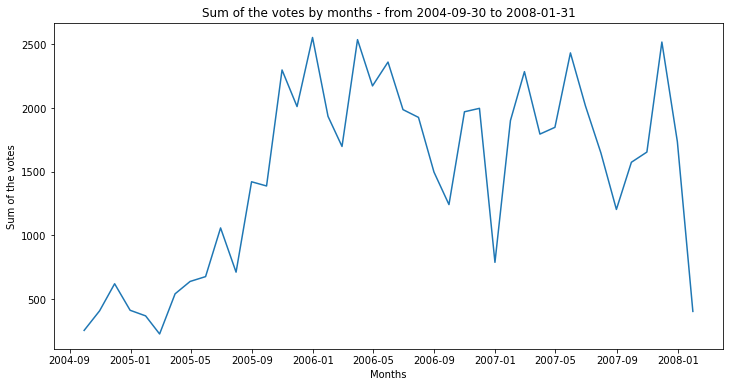

In [16]:
# sum of the votes
sign_sum = sign_time.groupby(pd.Grouper(key="Time", freq="M")).sum()
print(sign_sum.tail())

fig = plt.figure(figsize=(12,6))
plt.plot(sign_sum)
plt.xlabel('Months')
plt.ylabel('Sum of the votes')
plt.title('Sum of the votes by months - from 2004-09-30 to 2008-01-31');

# Interpretation:
# majority of the votes are postive

                Sign
Time                
2007-09-30  0.481640
2007-10-31  0.533376
2007-11-30  0.623946
2007-12-31  0.498563
2008-01-31  0.641270


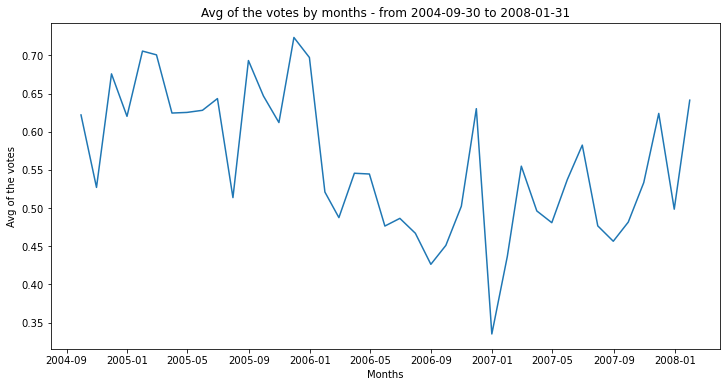

In [17]:
# avg of the votes
sign_avg = sign_time.groupby(pd.Grouper(key="Time", freq="M")).mean()
print(sign_avg.tail())

fig = plt.figure(figsize=(12,6))
plt.plot(sign_avg)
plt.xlabel('Months')
plt.ylabel('Avg of the votes')
plt.title('Avg of the votes by months - from 2004-09-30 to 2008-01-31');

# Interpretation: large drop in positive vote in Jan 2007
# Some pattern?

### By week

                Sign
Time                
2007-12-09  0.560704
2007-12-16  0.451745
2007-12-23  0.661512
2007-12-30  0.358678
2008-01-06  0.569638


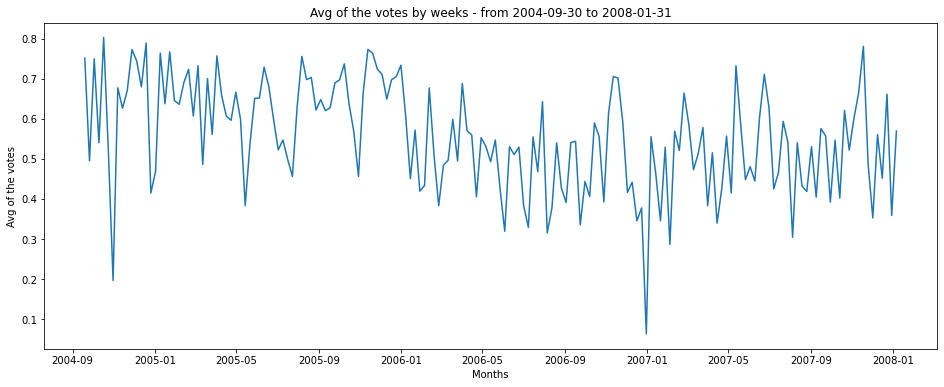

In [18]:
# avg of the votes
sign_avg_w = sign_time.groupby(pd.Grouper(key="Time", freq="W")).mean()
print(sign_avg_w.tail())

fig = plt.figure(figsize=(16,6))
plt.plot(sign_avg_w)
plt.xlabel('Months')
plt.ylabel('Avg of the votes')
plt.title('Avg of the votes by weeks - from 2004-09-30 to 2008-01-31');

# Interpretation: looks like there is a kind of recurrent pattern 

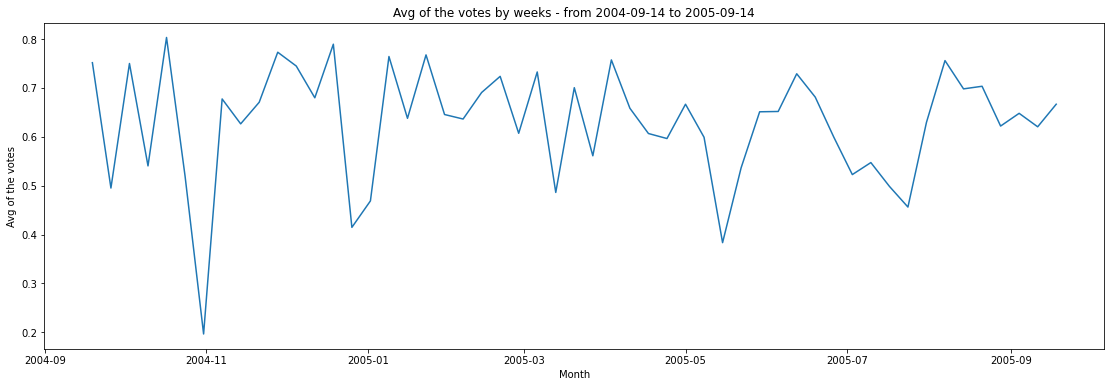

In [19]:
# subsample: focus on the left part of the graph
sample = wikipedia[(wikipedia.Time >= '2004-09-14') & (wikipedia.Time <= '2005-09-14')]
sample = sample[['Sign','Time']]

sign_avg_w = sample.groupby(pd.Grouper(key="Time", freq="W")).mean()

fig = plt.figure(figsize=(19,6))
plt.plot(sign_avg_w)
plt.xlabel('Month')
plt.ylabel('Avg of the votes')
plt.title('Avg of the votes by weeks - from 2004-09-14 to 2005-09-14');

# seems like people are less postive at the end of the month ??
# looks like the priod is around 40 days... weird

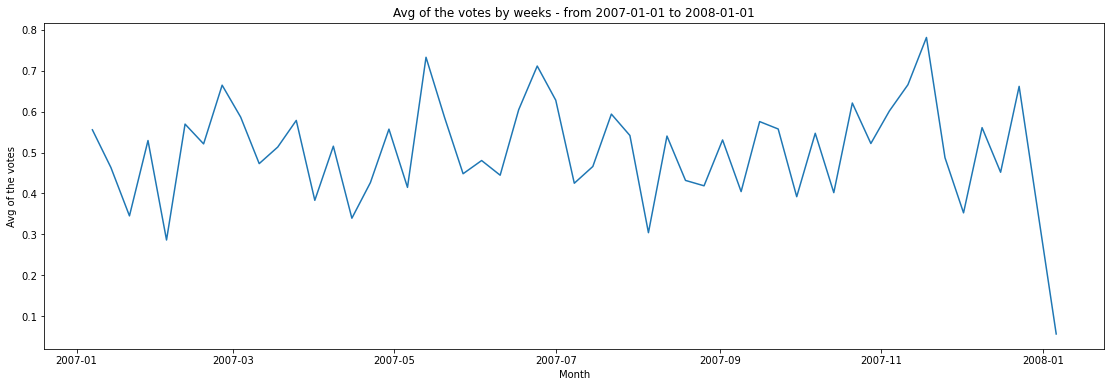

In [20]:
# subsample: focus on the right part of the graph
sample = wikipedia[(wikipedia.Time >= '2007-01-01') & (wikipedia.Time <= '2008-01-01')]
sample = sample[['Sign','Time']]

sign_avg_w = sample.groupby(pd.Grouper(key="Time", freq="W")).mean()

fig = plt.figure(figsize=(19,6))
plt.plot(sign_avg_w)
plt.xlabel('Month')
plt.ylabel('Avg of the votes')
plt.title('Avg of the votes by weeks - from 2007-01-01 to 2008-01-01');

# seems like people are less postive at the end of the month ??
# looks like the priod is around 40 days... weird

## Duplicates 
We want to investigate the vote distributions for repeated elections, meaning when the same candidate seeks adminship several times. For this to be possible, we have to chack that we indeed have enough duplicates in our dataset in order to conduct a meaningful analysis.

In [21]:
wikipedia.head()

,Voter,Candidate,Sign,Time
0,3,30,1,2004-09-14 16:26:00
1,25,30,-1,2004-09-14 16:53:00
2,4,30,1,2004-09-14 17:08:00
3,5,30,1,2004-09-14 17:37:00
4,6,30,1,2004-09-14 19:28:00


In [22]:
wikipedia.shape

(113239, 4)

In [23]:
duplicated = wikipedia[ wikipedia[['Voter','Candidate']].duplicated(keep=False) ] # keep=False to keep all duplicates
duplicated
# duplicate in this context = when a voter voted for the same candidate several time
# we have a lot of duplicates : ~7500

,Voter,Candidate,Sign,Time
135,11,8,1,2004-09-15 04:30:00
136,75,8,1,2004-09-15 04:35:00
143,79,8,-1,2004-09-15 22:18:00
144,25,8,-1,2004-09-16 05:47:00
323,23,151,-1,2004-09-20 21:40:00
...,...,...,...,...
113830,7080,7924,1,2008-01-04 20:03:00
113835,5998,7924,1,2008-01-05 02:29:00
113842,6072,7924,1,2008-01-05 19:12:00
113849,6596,7924,0,2008-01-05 23:55:00


In [24]:
# But on average, how many time did a voter voted for the same candidate?

voter_candidate = wikipedia[['Voter','Candidate']]
# voter_candidate = voter_candidate[voter_candidate.duplicated()]
count_duplicated = voter_candidate.groupby(voter_candidate.columns.tolist(),as_index=False).size()
count_duplicated

,Voter,Candidate,size
0,3,28,1
1,3,30,1
2,3,39,1
3,3,54,1
4,3,94,1
...,...,...,...
109375,8270,7833,1
109376,8271,7833,1
109377,8272,4940,1
109378,8273,4940,1


In [25]:
count_duplicated['size'].describe()

# Interpretation
# Most of the voter voted a single time for a given candidate 
# but some voted up to 5 times for the same candidate

count    109380.000000
mean          1.035281
std           0.197463
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           5.000000
Name: size, dtype: float64

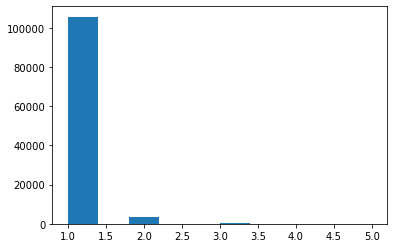

In [26]:
# Histo of the duplicates (1= no duplication)
plt.hist(count_duplicated['size']);

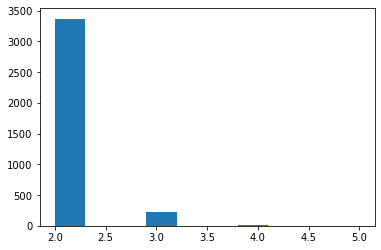

In [27]:
# Histo of the duplicates 

count_duplicated_tmp = count_duplicated[count_duplicated['size']>1]

plt.hist(count_duplicated_tmp['size']);

# Interpretation:
# More than 3000 people voted at least 2 times for the same candidate